In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the same MT5 data used earlier
df = pd.read_csv("EURUSD_H1_MT5.csv", index_col=0, parse_dates=True)

df.head()

,open,high,low,close,tick_volume
time,,,,,
2019-01-02 06:00:00,1.14454,1.14469,1.14427,1.14454,702
2019-01-02 07:00:00,1.14452,1.14788,1.14452,1.14787,1535
2019-01-02 08:00:00,1.14779,1.14967,1.14769,1.14853,2062
2019-01-02 09:00:00,1.14848,1.14928,1.14734,1.14761,4049
2019-01-02 10:00:00,1.14760,1.14776,1.14282,1.14477,7309


In [5]:
# Calculate EMA 10 and EMA 50 using closing prices

df["ema_10"] = df["close"].ewm(span=10, adjust=False).mean()
df["ema_50"] = df["close"].ewm(span=50, adjust=False).mean()

In [7]:
# Signal column:
#  1  -> Buy signal
# -1  -> Sell signal
#  0  -> No signal

df["signal"] = 0

df.loc[
    (df["ema_10"] > df["ema_50"]) &
    (df["ema_10"].shift(1) <= df["ema_50"].shift(1)),
    "signal"
] = 1

df.loc[
    (df["ema_10"] < df["ema_50"]) &
    (df["ema_10"].shift(1) >= df["ema_50"].shift(1)),
    "signal"
] = -1

In [9]:
# Calculate True Range (TR)

df["prev_close"] = df["close"].shift(1)

df["tr"] = df[["high", "prev_close"]].max(axis=1) - df[["low", "prev_close"]].min(axis=1)

# ATR using a 14-period EMA
df["atr"] = df["tr"].ewm(span=14, adjust=False).mean()

In [11]:
# Trade state variables

position = 0          # 1 = long, -1 = short, 0 = flat
entry_price = None
stop_loss = None

ATR_MULTIPLIER = 2.0

trades = []

In [13]:
# Main backtest loop

for i in range(1, len(df)):
    price = df["close"].iloc[i]
    high = df["high"].iloc[i]
    low  = df["low"].iloc[i]
    atr  = df["atr"].iloc[i]
    time = df.index[i]

    # Entry logic
    if position == 0:
        if df["signal"].iloc[i] == 1:
            position = 1
            entry_price = price
            stop_loss = entry_price - ATR_MULTIPLIER * atr
            trades.append({
                "type": "BUY",
                "entry": entry_price,
                "entry_time": time
            })

        elif df["signal"].iloc[i] == -1:
            position = -1
            entry_price = price
            stop_loss = entry_price + ATR_MULTIPLIER * atr
            trades.append({
                "type": "SELL",
                "entry": entry_price,
                "entry_time": time
            })

    # Manage long position
    elif position == 1:
        stop_loss = max(stop_loss, high - ATR_MULTIPLIER * atr)

        if low <= stop_loss:
            trades[-1]["exit"] = stop_loss
            trades[-1]["exit_time"] = time
            position = 0

    # Manage short position
    elif position == -1:
        stop_loss = min(stop_loss, low + ATR_MULTIPLIER * atr)

        if high >= stop_loss:
            trades[-1]["exit"] = stop_loss
            trades[-1]["exit_time"] = time
            position = 0

In [15]:
trades_df = pd.DataFrame(trades)

# Profit calculation
trades_df["pnl"] = trades_df.apply(
    lambda x: (x["exit"] - x["entry"]) if x["type"] == "BUY"
    else (x["entry"] - x["exit"]),
    axis=1
)

trades_df.head()

,type,entry,entry_time,exit,exit_time,pnl
0,BUY,1.14787,2019-01-02 07:00:00,1.147735,2019-01-02 08:00:00,-0.000135
1,SELL,1.14047,2019-01-02 14:00:00,1.135056,2019-01-03 00:00:00,0.005414
2,BUY,1.14049,2019-01-04 02:00:00,1.139133,2019-01-04 15:00:00,-0.001357
3,SELL,1.13501,2019-01-04 16:00:00,1.138706,2019-01-04 17:00:00,-0.003696
4,BUY,1.14083,2019-01-04 18:00:00,1.141102,2019-01-07 09:00:00,0.000272


In [17]:
total_trades = len(trades_df)
winning_trades = (trades_df["pnl"] > 0).sum()
losing_trades = (trades_df["pnl"] <= 0).sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0

total_pnl = trades_df["pnl"].sum()
avg_win = trades_df.loc[trades_df["pnl"] > 0, "pnl"].mean()
avg_loss = trades_df.loc[trades_df["pnl"] <= 0, "pnl"].mean()

print(f"Total trades      : {total_trades}")
print(f"Winning trades    : {winning_trades}")
print(f"Losing trades     : {losing_trades}")
print(f"Win rate          : {win_rate:.2%}")
print(f"Total PnL         : {total_pnl:.5f}")
print(f"Average win       : {avg_win:.5f}")
print(f"Average loss      : {avg_loss:.5f}")

Total trades      : 930
Winning trades    : 288
Losing trades     : 642
Win rate          : 30.97%
Total PnL         : -0.45784
Average win       : 0.00184
Average loss      : -0.00154


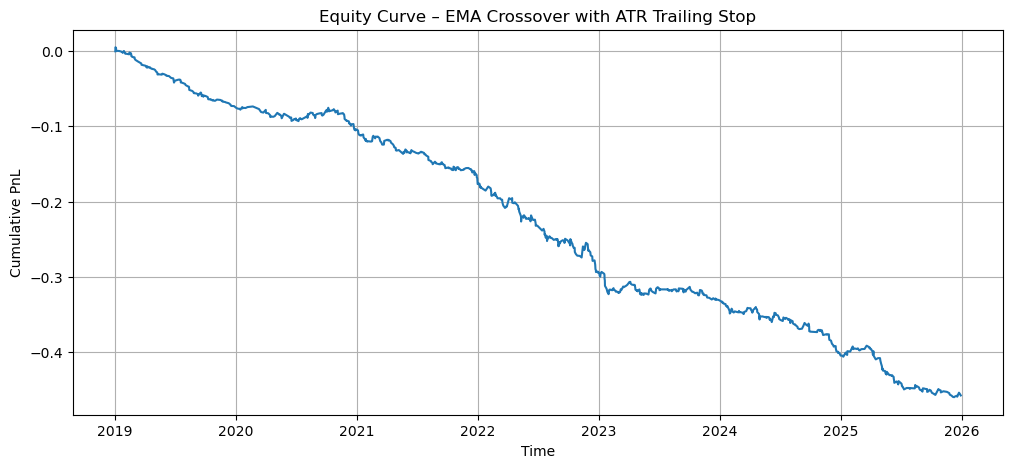

In [19]:
trades_df["cum_pnl"] = trades_df["pnl"].cumsum()

plt.figure(figsize=(12,5))
plt.plot(trades_df["exit_time"], trades_df["cum_pnl"])
plt.title("Equity Curve – EMA Crossover with ATR Trailing Stop")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()
